In [1]:
import datetime as dt
import re
import pandas as pd


def containsNumber(value):
    for character in value:
        if character.isdigit():
            return True
    return False


def get_high_reps(s):
    if "," in s:
        reps = [float(x) for x in s.split(",")]
        return float(max(reps))

    elif "x" in s:
        return float(s.split("x")[-1])

    else:
        return float(s)


# import data from notes and put it in a list
with open("data/liftingpostcovid.txt", "r") as data:
    rawNotes = [(line.strip()).split() for line in data]
rawNotes = [x for x in rawNotes if x]

curr_date = dt.datetime.strptime("1/1/20", "%m/%d/%y")

data = []
for row in rawNotes:
    lift = []
    weight = None
    reps = None
    notes = []
    try:
        for val in row:
            if "/" in val and len(row) == 1:
                curr_date = dt.datetime.strptime(val, "%m/%d/%y")
                day = True
                break
            elif re.fullmatch(r"^\D*$", val) and not weight:
                lift.append(val.lower())

            elif containsNumber(val) and ',' not in val and not weight:
                _ = re.sub(r"[^\d.]", "", val)
                weight = float(_)

            elif containsNumber(val) and ":" not in val and not reps:
                reps = min(get_high_reps(val), 15)
            else:
                notes.append(val)
        lift = " ".join(lift)
        if notes:
            notes = " ".join(notes)
        else:
            notes = None
        data.append((curr_date, lift, weight, reps, notes))
    except Exception as e:
        print(row, e, curr_date)

df = pd.DataFrame(data, columns=["date", "lift", "weight", "high_reps", "notes"])
df['high_reps'] = df['high_reps'].fillna(0)
df["e1rm"] = round(df["weight"] * (36 / (37 - df["high_reps"].clip(0,13))), 1)


print(df.tail(5))


['Curls', '65', '10ish'] could not convert string to float: '10ish' 2015-09-07 00:00:00
['Bar', 'holds', '2x30s', '85lbs'] could not convert string to float: '85lbs' 2015-10-16 00:00:00
['Bar', 'holds', '95lbs', '2x30s', 'Russian', 'twist', '10', '3x35', 'Rear', 'delt', 'flyes'] could not convert string to float: '30s' 2015-10-19 00:00:00
['Deadlift', 'week', '2', '365max'] could not convert string to float: '' 2015-10-21 00:00:00
['Bar', 'holds', '35', 'lbs', '2x17sec'] could not convert string to float: '17sec' 2015-10-22 00:00:00
['Rows', '125x8,', 'OHP', '125', '3x4'] could not convert string to float: '125x8' 2015-10-26 00:00:00
['Squat', '275', '4x5?'] could not convert string to float: '5?' 2015-11-14 00:00:00
['Pin', 'press', '220/225', '3-5', 'reps', '5', 'sets'] could not convert string to float: '3-5' 2015-11-20 00:00:00
['Cg', '175', '5,', '5,6'] could not convert string to float: '' 2015-12-04 00:00:00
['Front', 'raises', '40', '3x10ish'] could not convert string to float:

In [2]:
df = df.loc[~(df.lift == '')].copy()
df['weight'] = df['weight'].fillna(0)
df

,date,lift,weight,high_reps,notes,e1rm
1,2015-09-07,squat,245.0,1.0,None,245.0
2,2015-09-07,deadlift,195.0,3.0,None,206.5
3,2015-09-07,pullups,77.0,0.0,None,74.9
5,2015-09-08,front squat,195.0,1.0,None,195.0
6,2015-09-08,bench,180.0,5.0,easy,202.5
...,...,...,...,...,...,...
7894,2024-06-28,curls,0.0,0.0,None,NaN
7896,2024-06-29,bench,235.0,10.0,None,313.3
7897,2024-06-29,bench,225.0,7.0,None,270.0
7898,2024-06-29,side delts,0.0,0.0,None,NaN


In [3]:
import matplotlib.pyplot as plt

In [4]:
df.loc[~(df.e1rm.isna()) & (df.lift == 'squat')].sort_values(by='e1rm').tail(5)

,date,lift,weight,high_reps,notes,e1rm
6371,2023-01-16,squat,405.0,3.0,None,428.8
2028,2019-06-05,squat,335.0,9.0,None,430.7
2132,2019-07-09,squat,335.0,9.0,"225 8,8",430.7
2070,2019-06-19,squat,325.0,10.0,None,433.3
1529,2018-08-13,squat,315.0,15.0,"Or 2,3,3",472.5


In [5]:
df['day'] = df['date'] - pd.to_datetime('2015-09-01')
df['week'] = df['day'].dt.days.astype(int) // 7
df

,date,lift,weight,high_reps,notes,e1rm,day,week
1,2015-09-07,squat,245.0,1.0,None,245.0,6 days,0
2,2015-09-07,deadlift,195.0,3.0,None,206.5,6 days,0
3,2015-09-07,pullups,77.0,0.0,None,74.9,6 days,0
5,2015-09-08,front squat,195.0,1.0,None,195.0,7 days,1
6,2015-09-08,bench,180.0,5.0,easy,202.5,7 days,1
...,...,...,...,...,...,...,...,...
7894,2024-06-28,curls,0.0,0.0,None,NaN,3223 days,460
7896,2024-06-29,bench,235.0,10.0,None,313.3,3224 days,460
7897,2024-06-29,bench,225.0,7.0,None,270.0,3224 days,460
7898,2024-06-29,side delts,0.0,0.0,None,NaN,3224 days,460


<Axes: xlabel='Date', ylabel='Estimated ohp 1 Rep Max'>

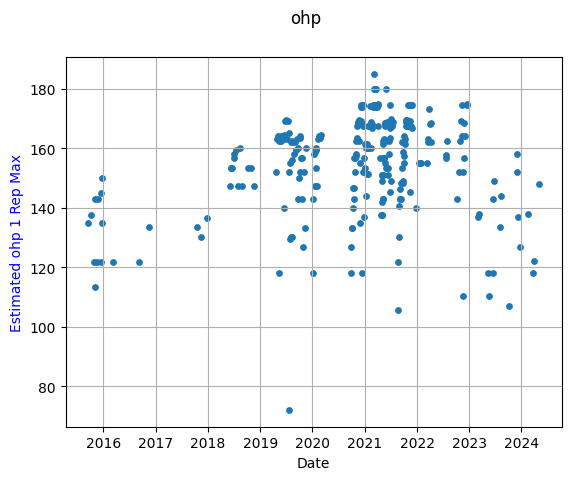

In [29]:
def plot_lift(lift_name, df):
    df = df.loc[df.lift==lift_name].copy(deep=True).reset_index(drop=True)
    plt.figure()
    plt.scatter(df['date'], df['e1rm'], s=15)
    plt.xlabel("Date")
    plt.ylabel("Estimated " + str(lift_name) + " 1 Rep Max", color='blue')
    ax1 = plt.gca()
    n = 1  # Keeps every nth label
    [
        l.set_visible(False)
        for (i, l) in enumerate(ax1.xaxis.get_ticklabels())
        if i % n != 0
    ]
    plt.grid(True)
    plt.suptitle(lift_name)
    plt.savefig(f'plots/{lift_name}_e1RM')
    #ax.table(cellText=data, colLabels=column_labels, loc="center")
    return ax1

plot_lift('ohp', df)

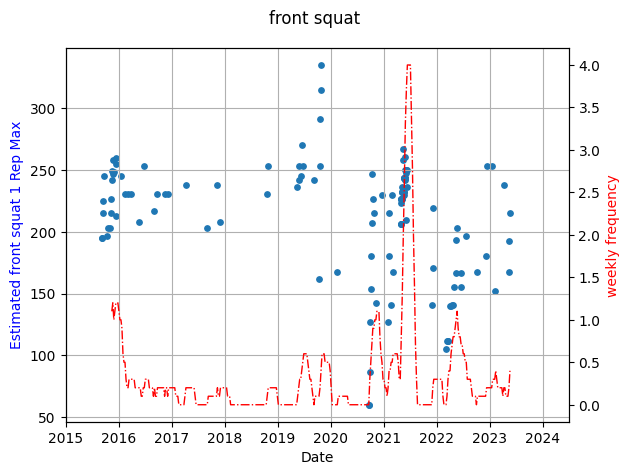

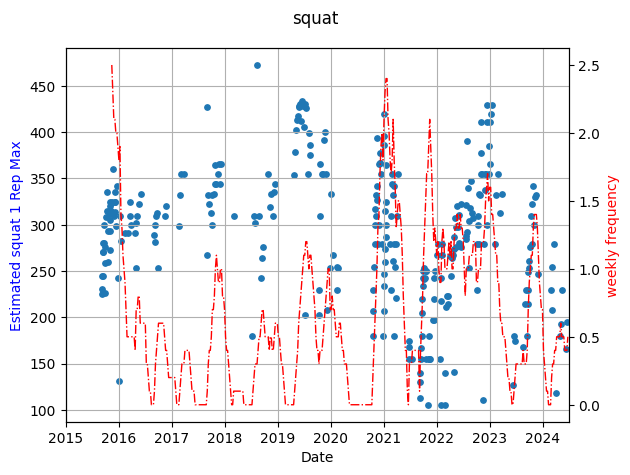

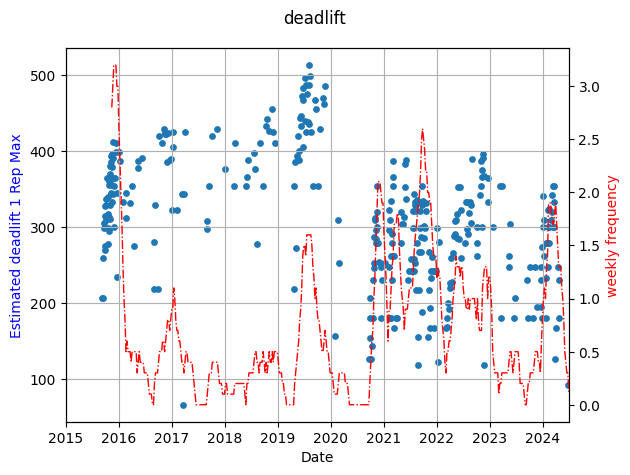

In [34]:
def freq_and_strength(df,lift):

    ax1 = plot_lift(lift, df)
    ax1.set_xlim([pd.to_datetime('2015-01-01'), df['date'].max()])
    bench = df.loc[df.lift == lift].groupby(pd.Grouper(key='date', freq='D'))['lift'].value_counts().reset_index()
    bench = bench.set_index('date').resample("1D").asfreq().fillna(0).reset_index()
    y = bench.groupby(pd.Grouper(key='date', freq='W'))['count'].sum().reset_index()
    y['avg'] = y['count'].rolling(10).mean()

    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    ax2.set_ylabel('weekly frequency', color='red')  # we already handled the x-label with ax1
    ax2.plot(y['date'], y['avg'], color='red', linestyle='-.', linewidth=1)
    ax2.tick_params(axis='y')
    fig = plt.gcf()
    fig.tight_layout()
    plt.show()

    #display(y.sort_values(by='count'))
    return
freq_and_strength(df,'front squat')
freq_and_strength(df,'squat')
freq_and_strength(df,'deadlift')

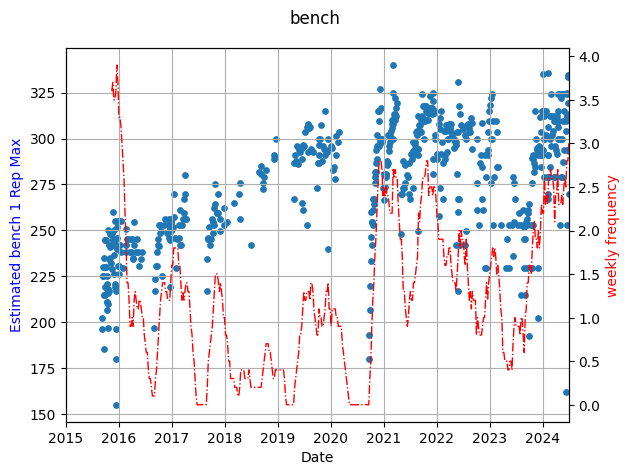

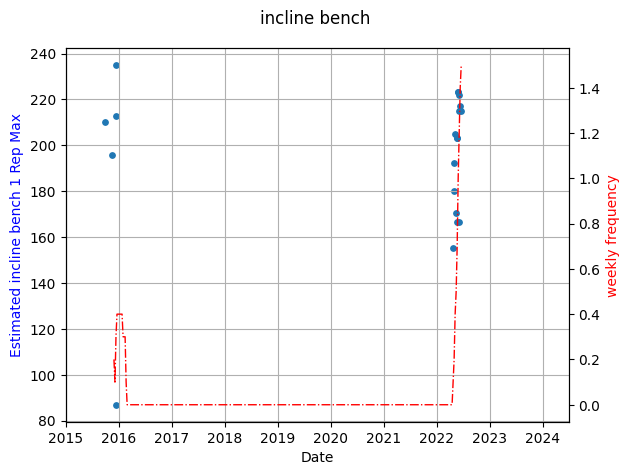

In [39]:
freq_and_strength(df,'bench')
freq_and_strength(df,'incline bench')

In [10]:
def plot_freq(df, lift):
    df_ = df.copy(deep=True).set_index('date').resample("1D").asfreq().fillna(0).reset_index()
    x =df_.loc[df_.lift == lift].groupby(pd.Grouper(key='date', freq='D'))['lift'].value_counts().reset_index()
    x = x.drop('count',axis=1)
    y = x.groupby(pd.Grouper(key='date', freq='W'))['lift'].value_counts().reset_index()
    y['avg'] = y['count'].rolling(10).mean()
    plt.plot(y['date'], y['avg'])
    plt.show()
    return 

plot_freq(df, 'squat')
#plot_freq(df, 'bench')

ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
y.sort_values(by='count')

,week,lift,count,avg
0,0,squat,1,NaN
102,276,squat,1,2.0
174,388,squat,1,1.4
200,453,squat,1,1.2
175,389,squat,1,1.4
...,...,...,...,...
137,335,squat,3,1.2
97,271,squat,3,1.7
1,1,squat,3,NaN
161,370,squat,3,1.7


In [ ]:
df.loc[(df.week==2) & (df.lift=='squat')]

,date,lift,weight,high_reps,notes,e1rm,day,week
25,2015-09-15,squat,245.0,1.0,left knee hurt,245.0,14 days,2
33,2015-09-17,squat,280.0,1.0,None,280.0,16 days,2
37,2015-09-18,squat,270.0,1.0,None,270.0,17 days,2
45,2015-09-21,squat,280.0,1.0,None,280.0,20 days,2
